In [6]:
import tensorflow as tf
import numpy as np

In [7]:
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/home/tur/tmp/gender/gender",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "/home/tur/tmp/gender/gender",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1337,
)
#raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
#    "aclImdb/test", batch_size=batch_size
#)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
#print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")


Found 1265 files belonging to 4 classes.
Using 1012 files for training.
Found 1265 files belonging to 4 classes.
Using 253 files for validation.
Number of batches in raw_train_ds: 32
Number of batches in raw_val_ds: 8


In [43]:
# It's important to take a look at your raw data to ensure your normalization
# and tokenization will work as expected. We can do that by taking a few
# examples from the training set and looking at them.
# This is one of the places where eager execution shines:
# we can just evaluate these tensors using .numpy()
# instead of needing to evaluate them in a Session/Graph context.
lab, pred = [], []
for text_batch, label_batch in raw_train_ds.take(30):
    for i in range(32):
        txt = text_batch.numpy()[i]
        lab.append(label_batch.numpy()[i].argmax())
        pred.append(end_to_end_model.predict([txt]).argmax())

2022-08-17 11:07:50.731515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 54 of 256
2022-08-17 11:08:00.706828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 118 of 256
2022-08-17 11:08:16.625145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 146 of 256
2022-08-17 11:08:20.926626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 180 of 256
2022-08-17 11:08:30.718144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 248 of 256
2022-08-17 11:08:32.055458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


[[  0   0   3   3]
 [  0   0 179   2]
 [  0   0 708   6]
 [  0   0   0  59]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00       181
           2       0.80      0.99      0.88       714
           3       0.84      1.00      0.91        59

    accuracy                           0.80       960
   macro avg       0.41      0.50      0.45       960
weighted avg       0.64      0.80      0.71       960



/home/tur/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tur/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tur/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


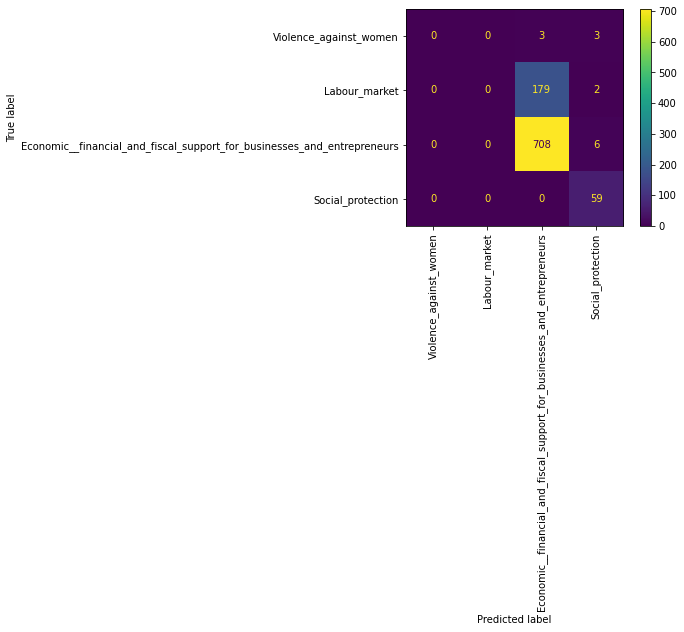

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(lab,pred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(xticks_rotation=90)
print(classification_report(lab, pred))

In [9]:
from tensorflow.keras.layers import TextVectorization
import string
import re

# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML). Because of this, we will need to
# create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )


# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)


2022-08-17 10:19:23.792224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 75 of 256
2022-08-17 10:19:34.717319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 152 of 256
2022-08-17 10:19:43.920118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 256
2022-08-17 10:19:53.764600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 226 of 256
2022-08-17 10:19:57.951646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
#test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
#test_ds = test_ds.cache().prefetch(buffer_size=10)


In [11]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(4, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [12]:
epochs = 4

# Fit the model using the train and test datasets.
hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/4


2022-08-17 10:22:14.242063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 69 of 256
2022-08-17 10:22:24.558659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 112 of 256
2022-08-17 10:22:34.314574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 164 of 256
2022-08-17 10:22:44.262766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 235 of 256
2022-08-17 10:22:47.016848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


32/32 [==============================] - ETA: 0s - loss: 0.8227 - accuracy: 0.7263

2022-08-17 10:25:30.525285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 73 of 256
2022-08-17 10:25:40.347220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 110 of 256
2022-08-17 10:25:50.312507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 191 of 256
2022-08-17 10:25:59.328157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


32/32 [==============================] - 243s 6s/step - loss: 0.8227 - accuracy: 0.7263 - val_loss: 0.6143 - val_accuracy: 0.7549
Epoch 2/4
32/32 [==============================] - 4s 114ms/step - loss: 0.6604 - accuracy: 0.7372 - val_loss: 0.5676 - val_accuracy: 0.7549
Epoch 3/4
32/32 [==============================] - 4s 115ms/step - loss: 0.6204 - accuracy: 0.7500 - val_loss: 0.5442 - val_accuracy: 0.8103
Epoch 4/4
32/32 [==============================] - 4s 112ms/step - loss: 0.5809 - accuracy: 0.7875 - val_loss: 0.5112 - val_accuracy: 0.8103


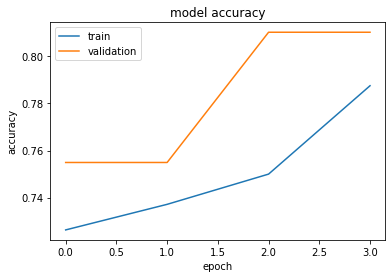

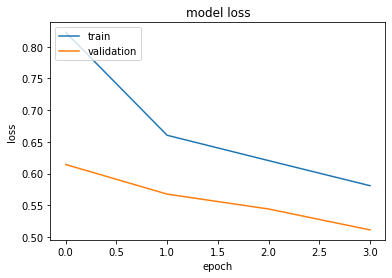

In [13]:
history = hist
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
# Make an end-to-end model

In [15]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
#end_to_end_model.evaluate(raw_test_ds)


In [16]:
import os
for root, dirs, files in os.walk("/home/tur/tmp/gender/gender"):
    labels = dirs
    print(labels)
    break

['Violence_against_women', 'Labour_market', 'Economic__financial_and_fiscal_support_for_businesses_and_entrepreneurs', 'Social_protection']


In [17]:
#labels = [,,'Social_protection','Violence_against_women']

In [18]:
with open("/home/tur/tmp/gender/gender/Economic__financial_and_fiscal_support_for_businesses_and_entrepreneurs/2506.txt",'r') as f:
    txt = f.read()

In [19]:
ret = end_to_end_model.predict([txt])
print(ret, ret.argmax())
labels[ret.argmax()]

[[0.04780519 0.13133842 0.196897   0.62395936]] 3


'Social_protection'

In [20]:
end_to_end_model.save('keras_cls_1.model')

2022-08-17 10:26:19.397871: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: keras_cls_1.model/assets
